<a href="https://colab.research.google.com/github/Vaycold/Python_DL/blob/main/Image_Transformation/AutoEncoder%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EB%B6%84%ED%95%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal
```
 - 작게 줄인 PFCN 데이터를 이용하여 사람 영역 추출
 - 큰 사진을 작게 줄이기
 - 이미지에 대한 Autoencoder식 접근


In [1]:
# Import package

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from google.colab import drive
from IPython.display import Image

warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
os.listdir()

['.config', 'MyDrive', 'sample_data']

In [ ]:
os.listdir('MyDrive/MyDrive/fastcampus/DL_300/이미지변환/dataset')

['ReadMe.txt', 'training', 'testing', 'pfcn_small.npz']

## Dataload

In [ ]:
#train_path = 'MyDrive/MyDrive/fastcampus/DL_300/이미지변환/dataset/training' # 
#test_path = 'MyDrive/MyDrive/fastcampus/DL_300/이미지변환/dataset/testing'

In [ ]:
import imageio
x = imageio.imread(train_path+'/00001.png')
y = imageio.imread(train_path+'/00001_matte.png')

# 이러한 방식이 있다고만 알아두자

In [ ]:
print(x.shape, y.shape)

(800, 600, 3) (800, 600)


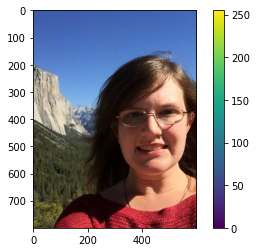

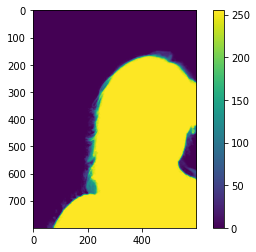

In [ ]:
# visualizing x & y
plt.imshow(x)
plt.colorbar()
plt.show()
plt.imshow(y)
plt.colorbar()
plt.show()

In [ ]:
# Decrease the dataset's size // (800,600,3) -> (100,75,3) // (800,600) -> (100,75)
from skimage.transform import resize
x1 = resize(x, (100,75))
y1 = resize(y, (100,75))

In [ ]:
print(x1.shape, y1.shape)

(100, 75, 3) (100, 75)


In [ ]:
# 위 방식대로 줄일 수도 있지만 그냥 줄인 파일을 다운받아서 사용하기로 하자.

In [3]:
os.listdir('MyDrive/MyDrive/fastcampus/DL_300/이미지변환/dataset')

['ReadMe.txt', 'training', 'testing', 'pfcn_small.npz']

In [4]:
# Data load
dataset_path = 'MyDrive/MyDrive/fastcampus/DL_300/이미지변환/dataset'
pfcn_small = np.load(dataset_path + '/pfcn_small.npz')

In [5]:
pfcn_small['train_images'].shape

(1700, 100, 75, 3)

In [ ]:
pfcn_small['train_mattes'].shape

(1700, 100, 75)

In [ ]:
pfcn_small['test_images'].shape

(300, 100, 75, 3)

In [ ]:
pfcn_small['test_mattes'].shape

(300, 100, 75)

In [5]:
train_images = pfcn_small['train_images']
train_mattes = pfcn_small['train_mattes']
test_images = pfcn_small['test_images']
test_mattes = pfcn_small['test_mattes']

In [ ]:
# 0이 아닌 값들 출력
list(filter(lambda x : x !=0, train_images[0].reshape(-1)))[:10]

[0.2362745098039194,
 0.3480392156862709,
 0.6470588235294088,
 0.24509803921568626,
 0.3568627450980406,
 0.6558823529411772,
 0.2549019607843108,
 0.3647058823529383,
 0.6647058823529384,
 0.23725490196078006]

In [7]:
# 이 방법을 더 추천
train_images[train_images!=0]

array([0.23627451, 0.34803922, 0.64705882, ..., 0.05588235, 0.0245098 ,
       0.01470588])

## Pre-processing


In [8]:
# 최대값 최소값 확인
print(train_images.max(), train_images.min())

1.0 0.0


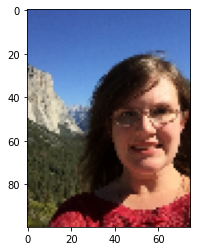

In [10]:
plt.imshow(train_images[0])

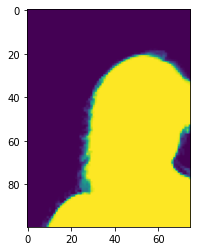

In [11]:
plt.imshow(train_mattes[0])

In [9]:
train_mattes[0].shape

(100, 75)

In [6]:
# mattes의 shape 변경
from skimage import color
train_mattes = np.array([color.rgb2gray(img).reshape((100,75,1)) for img in train_mattes])
test_mattes = np.array([color.rgb2gray(img).reshape((100,75,1)) for img in test_mattes])

In [15]:
train_mattes.shape

(1700, 100, 75, 1)

In [16]:
# 5 Train image visualizing
train_images[:5].shape

(5, 100, 75, 3)

In [17]:
np.hstack(
    train_images[:5]
).shape

(100, 375, 3)

In [19]:
train_images.transpose([1,0,2,3]).shape

(100, 1700, 75, 3)

In [22]:
train_images[:5].transpose([1,0,2,3]).reshape((100,-1,3)).shape

(100, 375, 3)

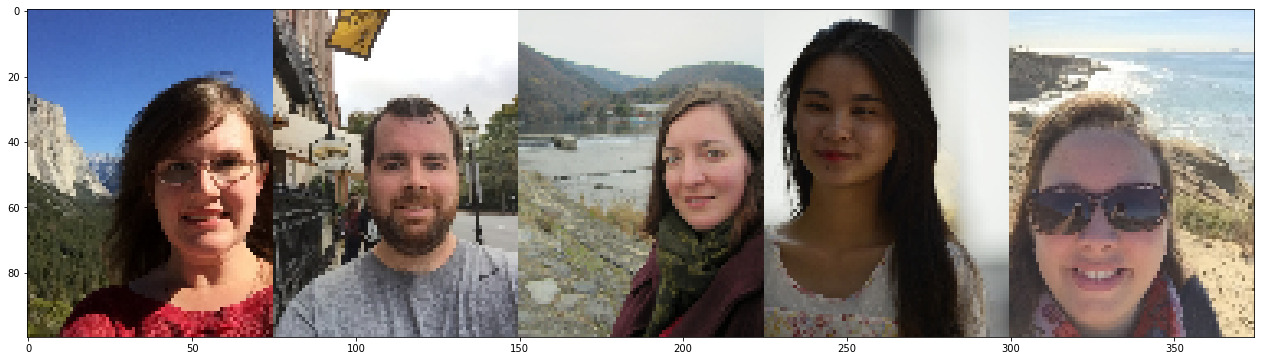

In [26]:
plt.figure(figsize=(22,7))
plt.imshow(train_images[:5].transpose([1,0,2,3]).reshape((100,-1,3)))
plt.show()

In [27]:
# mattee 출력
train_mattes[:5].shape

(5, 100, 75, 1)

In [31]:
train_mattes[:5].transpose([1,0,2,3]).reshape((100,-1,1)).shape

(100, 375, 1)

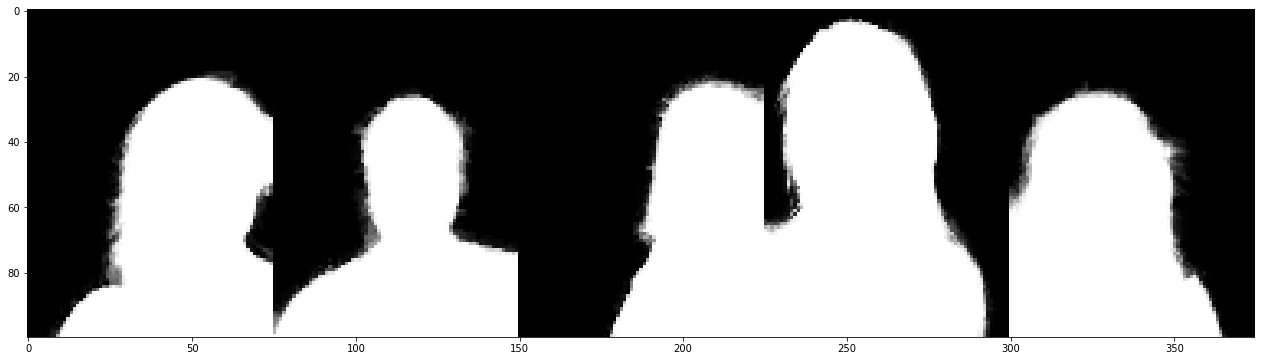

In [36]:
plt.figure(figsize=(22,7))
plt.imshow(train_mattes[:5].transpose([1,0,2,3]).reshape((100,-1,1))[:,:,0], cmap='gray')
plt.show()

## AutoEncoder Modeling


In [7]:
# portrait segmentation model
# input : (100, 75, 3) // output : (100, 75, 1)
from keras.layers import Dense, Input, Conv2D, UpSampling2D, Flatten, Reshape  # upsampling은 주어진 크기로 늘리는 역할을 수행함
from keras.models import Model

def ae_like() :
    inputs  = Input((100,75,3))
    x = Conv2D(32, 3, 2, activation = 'relu', padding='same')(inputs) # stride : 2 -> 2배씩 작아지는 역할
    x = Conv2D(64, 3, 2, activation = 'relu', padding ='same')(x)
    x = Conv2D(128, 3, 2, activation = 'relu', padding ='same')(x)
    x = Flatten()(x) # latent vector화
    latent = Dense(10)(x) # 10개 짜리로 줄여버렸음 이제 다시 커질 차례


    x = Dense((13*10*128))(latent) # 10으로 줄인걸 다시 16640으로 늘여버림.
    x = Reshape((13,10,128))(x) #요건 Flatten 되기 전 상태임. model.summary()로 확인가능
    
    x = UpSampling2D(size = (2,2))(x) # 2배씩 키우는 것임. # summary()로 보면 알 겠지만 2로 딱 나눠떨어진게 아니기 때문에 조금 다를 수 있음.
    x = Conv2D( 128, (2,2), (1,1), activation='relu', padding='valid')(x)
    
    x = UpSampling2D(size = (2,2))(x) 
    x = Conv2D( 64, (1,1), (1,1), activation='relu', padding='valid')(x) # 요거다음은 38이 75가 되야 되기 때문에수정이 조금 필요함

    x = UpSampling2D(size = (2,2))(x) 
    x = Conv2D( 32, (1,2), (1,1), activation='relu', padding='valid')(x)  # 맨앞에 32는 채널을 의미함. output 채널이 1이기 때문에 1로 바꿔주자

    x = Conv2D( 1, (1,1), (1,1), activation='sigmoid')(x)



    model = Model(inputs, x)
    return model
ae_like().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 75, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 38, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 19, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 10, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 16640)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                166410    
_________________________________________________________________
dense_1 (Dense)              (None, 16640)             183040

In [8]:
model = ae_like()

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 75, 3)]      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 38, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 19, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 10, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16640)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                166410    
_________________________________________________________________
dense_3 (Dense)              (None, 16640)             1830

In [10]:
# model accuracy 설정
model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [11]:
# Train
model.fit(train_images, train_mattes, 
          validation_data = (test_images, test_mattes),
          epochs = 25,
          verbose = 1
          )

Epoch 1/25
54/54 [==============================] - 34s 67ms/step - loss: 0.1656 - accuracy: 0.7154 - val_loss: 0.1255 - val_accuracy: 0.7627
Epoch 2/25
54/54 [==============================] - 3s 50ms/step - loss: 0.1262 - accuracy: 0.7630 - val_loss: 0.1200 - val_accuracy: 0.7690
Epoch 3/25
54/54 [==============================] - 3s 50ms/step - loss: 0.1138 - accuracy: 0.7792 - val_loss: 0.0944 - val_accuracy: 0.8073
Epoch 4/25
54/54 [==============================] - 3s 50ms/step - loss: 0.0900 - accuracy: 0.8121 - val_loss: 0.0833 - val_accuracy: 0.8180
Epoch 5/25
54/54 [==============================] - 3s 50ms/step - loss: 0.0822 - accuracy: 0.8220 - val_loss: 0.0799 - val_accuracy: 0.8228
Epoch 6/25
54/54 [==============================] - 3s 49ms/step - loss: 0.0745 - accuracy: 0.8321 - val_loss: 0.0752 - val_accuracy: 0.8295
Epoch 7/25
54/54 [==============================] - 3s 49ms/step - loss: 0.0663 - accuracy: 0.8431 - val_loss: 0.0722 - val_accuracy: 0.8331
Epoch 8/25
5

In [13]:
# 결과확인
res = model.predict(test_images[0:1])

In [14]:
res.shape

(1, 100, 75, 1)

In [ ]:
np.concatenate()

## Goal
```
 - 작게 줄인 PFCN 데이터를 이용하여 사람 영역 추출
 - 큰 사진을 작게 줄이기
 - 이미지에 대한 Autoencoder식 접근


## Goal
```
 - 작게 줄인 PFCN 데이터를 이용하여 사람 영역 추출
 - 큰 사진을 작게 줄이기
 - 이미지에 대한 Autoencoder식 접근


## Goal
```
 - 작게 줄인 PFCN 데이터를 이용하여 사람 영역 추출
 - 큰 사진을 작게 줄이기
 - 이미지에 대한 Autoencoder식 접근
